In [24]:
# install: tqdm (progress bars)
!pip install tqdm
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds
import matplotlib.pyplot as plt

You should consider upgrading via the 'pip install --upgrade pip' command.


## Load the data (CIFAR-10)

In [45]:
def load_cifar(datadir='./data_cache'): # will download ~400MB of data into this dir. Change the dir if neccesary. If using paperspace, you can make this /storage
    train_ds = ds.CIFAR10(root=datadir, train=True,
                           download=True, transform=None)
    test_ds = ds.CIFAR10(root=datadir, train=False,
                          download=True, transform=None)

    def to_xy(dataset):
        X = torch.Tensor(np.transpose(dataset.data, (0, 3, 1, 2))).float() / 255.0  # [0, 1]
        Y = torch.Tensor(np.array(dataset.targets)).long()
        return X, Y

    X_tr, Y_tr = to_xy(train_ds)
    X_te, Y_te = to_xy(test_ds)
    return X_tr, Y_tr, X_te, Y_te

def make_loader(dataset, batch_size=128):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,
            shuffle=True, num_workers=4, pin_memory=True)

X_tr, Y_tr, X_te, Y_te = load_cifar()
X_te_flipped = torch.flip(X_te, [2, 3])
train_dl = make_loader(TensorDataset(X_tr, Y_tr))
test_dl = make_loader(TensorDataset(X_te, Y_te))
flipped_test_dl = make_loader(TensorDataset(X_te_flipped, Y_te))

Files already downloaded and verified
Files already downloaded and verified


## Training helper functions

In [6]:
def train_epoch(model, train_dl : DataLoader, opt, k = 50):
    ''' Trains model for one epoch on the provided dataloader, with optimizer opt. Logs stats every k batches.'''
    loss_func = nn.CrossEntropyLoss()
    model.train()
    model.cuda()

    netLoss = 0.0
    nCorrect = 0
    nTotal = 0
    for i, (xB, yB) in enumerate(tqdm(train_dl)):
        opt.zero_grad()
        xB, yB = xB.cuda(), yB.cuda()
        outputs = model(xB)
        loss = loss_func(outputs, yB)
        loss.backward()
        opt.step()
        netLoss += loss.item() * len(xB)
        with torch.no_grad():
            _, preds = torch.max(outputs, dim=1)
            nCorrect += (preds == yB).float().sum()
            nTotal += preds.size(0)
        
        if (i+1) % k == 0:
            train_acc = nCorrect/nTotal
            avg_loss = netLoss/nTotal
            print(f'\t [Batch {i+1} / {len(train_dl)}] Train Loss: {avg_loss:.3f} \t Train Acc: {train_acc:.3f}')
  
    train_acc = nCorrect/nTotal
    avg_loss = netLoss/nTotal
    return avg_loss, train_acc


def evaluate(model, test_dl, loss_func=nn.CrossEntropyLoss().cuda()):
    ''' Returns loss, acc'''
    model.eval()
    model.cuda()
    nCorrect = 0.0
    nTotal = 0
    net_loss = 0.0
    with torch.no_grad():
        for (xb, yb) in test_dl:
            xb, yb = xb.cuda(), yb.cuda()
            outputs = model(xb)
            loss = len(xb) * loss_func(outputs, yb)
            _, preds = torch.max(outputs, dim=1)
            nCorrect += (preds == yb).float().sum()
            net_loss += loss
            nTotal += preds.size(0)

    acc = nCorrect.cpu().item() / float(nTotal)
    loss = net_loss.cpu().item() / float(nTotal)
    return loss, acc

170500096it [02:13, 1274216.58it/s] 


In [7]:
## Define model

In [9]:
## 5-Layer CNN for CIFAR
## This is the Myrtle5 network by David Page (https://myrtle.ai/learn/how-to-train-your-resnet-4-architecture/)

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), x.size(1))

def make_cnn(c=64, num_classes=10):
    ''' Returns a 5-layer CNN with width parameter c. '''
    return nn.Sequential(
        # Layer 0
        nn.Conv2d(3, c, kernel_size=3, stride=1,
                  padding=1, bias=True),
        nn.BatchNorm2d(c),
        nn.ReLU(),

        # Layer 1
        nn.Conv2d(c, c*2, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*2),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 2
        nn.Conv2d(c*2, c*4, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*4),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 3
        nn.Conv2d(c*4, c*8, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(c*8),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # Layer 4
        nn.MaxPool2d(4),
        Flatten(),
        nn.Linear(c*8, num_classes, bias=True)
    )

In [9]:
## Train

In [48]:
model = make_cnn()
opt = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 20
test_scores = []
flipped_test_scores = []
for i in range(epochs):
    print(f'Starting Epoch {i}')
    train_loss, train_acc = train_epoch(model, train_dl, opt)
    test_loss, test_acc = evaluate(model, test_dl)
    flipped_test_loss, flipped_test_acc = evaluate(model, flipped_test_dl)
    test_scores.append(test_acc)
    flipped_test_scores.append(flipped_test_acc)
    print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}\t Test Acc: {test_acc:.3f}')

Starting Epoch 0


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 6.340 	 Train Acc: 0.153
	 [Batch 100 / 391] Train Loss: 4.578 	 Train Acc: 0.184
	 [Batch 150 / 391] Train Loss: 3.756 	 Train Acc: 0.214
	 [Batch 200 / 391] Train Loss: 3.309 	 Train Acc: 0.237
	 [Batch 250 / 391] Train Loss: 3.017 	 Train Acc: 0.258
	 [Batch 300 / 391] Train Loss: 2.802 	 Train Acc: 0.277
	 [Batch 350 / 391] Train Loss: 2.641 	 Train Acc: 0.294
Epoch 0:	 Train Loss: 2.533 	 Train Acc: 0.307	 Test Acc: 0.378
Starting Epoch 1


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.531 	 Train Acc: 0.436
	 [Batch 100 / 391] Train Loss: 1.498 	 Train Acc: 0.454
	 [Batch 150 / 391] Train Loss: 1.465 	 Train Acc: 0.469
	 [Batch 200 / 391] Train Loss: 1.442 	 Train Acc: 0.478
	 [Batch 250 / 391] Train Loss: 1.417 	 Train Acc: 0.487
	 [Batch 300 / 391] Train Loss: 1.395 	 Train Acc: 0.497
	 [Batch 350 / 391] Train Loss: 1.379 	 Train Acc: 0.504
Epoch 1:	 Train Loss: 1.364 	 Train Acc: 0.509	 Test Acc: 0.466
Starting Epoch 2


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.151 	 Train Acc: 0.590
	 [Batch 100 / 391] Train Loss: 1.153 	 Train Acc: 0.589
	 [Batch 150 / 391] Train Loss: 1.128 	 Train Acc: 0.598
	 [Batch 200 / 391] Train Loss: 1.124 	 Train Acc: 0.600
	 [Batch 250 / 391] Train Loss: 1.107 	 Train Acc: 0.608
	 [Batch 300 / 391] Train Loss: 1.092 	 Train Acc: 0.614
	 [Batch 350 / 391] Train Loss: 1.078 	 Train Acc: 0.619
Epoch 2:	 Train Loss: 1.074 	 Train Acc: 0.621	 Test Acc: 0.614
Starting Epoch 3


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.939 	 Train Acc: 0.673
	 [Batch 100 / 391] Train Loss: 0.939 	 Train Acc: 0.673
	 [Batch 150 / 391] Train Loss: 0.925 	 Train Acc: 0.678
	 [Batch 200 / 391] Train Loss: 0.914 	 Train Acc: 0.682
	 [Batch 250 / 391] Train Loss: 0.907 	 Train Acc: 0.684
	 [Batch 300 / 391] Train Loss: 0.903 	 Train Acc: 0.686
	 [Batch 350 / 391] Train Loss: 0.899 	 Train Acc: 0.687
Epoch 3:	 Train Loss: 0.889 	 Train Acc: 0.690	 Test Acc: 0.566
Starting Epoch 4


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.816 	 Train Acc: 0.715
	 [Batch 100 / 391] Train Loss: 0.773 	 Train Acc: 0.732
	 [Batch 150 / 391] Train Loss: 0.767 	 Train Acc: 0.732
	 [Batch 200 / 391] Train Loss: 0.764 	 Train Acc: 0.732
	 [Batch 250 / 391] Train Loss: 0.763 	 Train Acc: 0.733
	 [Batch 300 / 391] Train Loss: 0.757 	 Train Acc: 0.736
	 [Batch 350 / 391] Train Loss: 0.755 	 Train Acc: 0.737
Epoch 4:	 Train Loss: 0.755 	 Train Acc: 0.737	 Test Acc: 0.730
Starting Epoch 5


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.609 	 Train Acc: 0.792
	 [Batch 100 / 391] Train Loss: 0.645 	 Train Acc: 0.780
	 [Batch 150 / 391] Train Loss: 0.642 	 Train Acc: 0.780
	 [Batch 200 / 391] Train Loss: 0.644 	 Train Acc: 0.778
	 [Batch 250 / 391] Train Loss: 0.636 	 Train Acc: 0.780
	 [Batch 300 / 391] Train Loss: 0.646 	 Train Acc: 0.777
	 [Batch 350 / 391] Train Loss: 0.643 	 Train Acc: 0.779
Epoch 5:	 Train Loss: 0.639 	 Train Acc: 0.780	 Test Acc: 0.713
Starting Epoch 6


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.547 	 Train Acc: 0.815
	 [Batch 100 / 391] Train Loss: 0.547 	 Train Acc: 0.813
	 [Batch 150 / 391] Train Loss: 0.553 	 Train Acc: 0.811
	 [Batch 200 / 391] Train Loss: 0.543 	 Train Acc: 0.815
	 [Batch 250 / 391] Train Loss: 0.551 	 Train Acc: 0.813
	 [Batch 300 / 391] Train Loss: 0.546 	 Train Acc: 0.814
	 [Batch 350 / 391] Train Loss: 0.547 	 Train Acc: 0.814
Epoch 6:	 Train Loss: 0.546 	 Train Acc: 0.814	 Test Acc: 0.617
Starting Epoch 7


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.442 	 Train Acc: 0.850
	 [Batch 100 / 391] Train Loss: 0.462 	 Train Acc: 0.841
	 [Batch 150 / 391] Train Loss: 0.468 	 Train Acc: 0.841
	 [Batch 200 / 391] Train Loss: 0.477 	 Train Acc: 0.839
	 [Batch 250 / 391] Train Loss: 0.481 	 Train Acc: 0.837
	 [Batch 300 / 391] Train Loss: 0.477 	 Train Acc: 0.838
	 [Batch 350 / 391] Train Loss: 0.482 	 Train Acc: 0.837
Epoch 7:	 Train Loss: 0.483 	 Train Acc: 0.837	 Test Acc: 0.735
Starting Epoch 8


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.367 	 Train Acc: 0.873
	 [Batch 100 / 391] Train Loss: 0.392 	 Train Acc: 0.869
	 [Batch 150 / 391] Train Loss: 0.393 	 Train Acc: 0.868
	 [Batch 200 / 391] Train Loss: 0.398 	 Train Acc: 0.865
	 [Batch 250 / 391] Train Loss: 0.400 	 Train Acc: 0.863
	 [Batch 300 / 391] Train Loss: 0.402 	 Train Acc: 0.863
	 [Batch 350 / 391] Train Loss: 0.399 	 Train Acc: 0.864
Epoch 8:	 Train Loss: 0.403 	 Train Acc: 0.862	 Test Acc: 0.710
Starting Epoch 9


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.318 	 Train Acc: 0.895
	 [Batch 100 / 391] Train Loss: 0.317 	 Train Acc: 0.892
	 [Batch 150 / 391] Train Loss: 0.322 	 Train Acc: 0.891
	 [Batch 200 / 391] Train Loss: 0.320 	 Train Acc: 0.893
	 [Batch 250 / 391] Train Loss: 0.333 	 Train Acc: 0.888
	 [Batch 300 / 391] Train Loss: 0.337 	 Train Acc: 0.887
	 [Batch 350 / 391] Train Loss: 0.339 	 Train Acc: 0.887
Epoch 9:	 Train Loss: 0.343 	 Train Acc: 0.887	 Test Acc: 0.783
Starting Epoch 10


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.238 	 Train Acc: 0.921
	 [Batch 100 / 391] Train Loss: 0.247 	 Train Acc: 0.918
	 [Batch 150 / 391] Train Loss: 0.278 	 Train Acc: 0.913
	 [Batch 200 / 391] Train Loss: 0.271 	 Train Acc: 0.913
	 [Batch 250 / 391] Train Loss: 0.264 	 Train Acc: 0.914
	 [Batch 300 / 391] Train Loss: 0.273 	 Train Acc: 0.912
	 [Batch 350 / 391] Train Loss: 0.275 	 Train Acc: 0.910
Epoch 10:	 Train Loss: 0.278 	 Train Acc: 0.909	 Test Acc: 0.776
Starting Epoch 11


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.155 	 Train Acc: 0.948
	 [Batch 100 / 391] Train Loss: 0.188 	 Train Acc: 0.939
	 [Batch 150 / 391] Train Loss: 0.218 	 Train Acc: 0.933
	 [Batch 200 / 391] Train Loss: 0.212 	 Train Acc: 0.934
	 [Batch 250 / 391] Train Loss: 0.211 	 Train Acc: 0.933
	 [Batch 300 / 391] Train Loss: 0.219 	 Train Acc: 0.931
	 [Batch 350 / 391] Train Loss: 0.218 	 Train Acc: 0.930
Epoch 11:	 Train Loss: 0.218 	 Train Acc: 0.930	 Test Acc: 0.783
Starting Epoch 12


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.127 	 Train Acc: 0.961
	 [Batch 100 / 391] Train Loss: 0.163 	 Train Acc: 0.956
	 [Batch 150 / 391] Train Loss: 0.165 	 Train Acc: 0.952
	 [Batch 200 / 391] Train Loss: 0.168 	 Train Acc: 0.949
	 [Batch 250 / 391] Train Loss: 0.162 	 Train Acc: 0.952
	 [Batch 300 / 391] Train Loss: 0.158 	 Train Acc: 0.953
	 [Batch 350 / 391] Train Loss: 0.160 	 Train Acc: 0.951
Epoch 12:	 Train Loss: 0.162 	 Train Acc: 0.950	 Test Acc: 0.820
Starting Epoch 13


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.055 	 Train Acc: 0.985
	 [Batch 100 / 391] Train Loss: 0.078 	 Train Acc: 0.979
	 [Batch 150 / 391] Train Loss: 0.076 	 Train Acc: 0.979
	 [Batch 200 / 391] Train Loss: 0.080 	 Train Acc: 0.978
	 [Batch 250 / 391] Train Loss: 0.096 	 Train Acc: 0.975
	 [Batch 300 / 391] Train Loss: 0.102 	 Train Acc: 0.973
	 [Batch 350 / 391] Train Loss: 0.102 	 Train Acc: 0.973
Epoch 13:	 Train Loss: 0.111 	 Train Acc: 0.970	 Test Acc: 0.800
Starting Epoch 14


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.045 	 Train Acc: 0.990
	 [Batch 100 / 391] Train Loss: 0.039 	 Train Acc: 0.992
	 [Batch 150 / 391] Train Loss: 0.040 	 Train Acc: 0.991
	 [Batch 200 / 391] Train Loss: 0.037 	 Train Acc: 0.992
	 [Batch 250 / 391] Train Loss: 0.035 	 Train Acc: 0.992
	 [Batch 300 / 391] Train Loss: 0.034 	 Train Acc: 0.993
	 [Batch 350 / 391] Train Loss: 0.033 	 Train Acc: 0.993
Epoch 14:	 Train Loss: 0.033 	 Train Acc: 0.993	 Test Acc: 0.837
Starting Epoch 15


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.012 	 Train Acc: 0.999
	 [Batch 100 / 391] Train Loss: 0.011 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.011 	 Train Acc: 0.999
	 [Batch 200 / 391] Train Loss: 0.011 	 Train Acc: 0.999
	 [Batch 250 / 391] Train Loss: 0.010 	 Train Acc: 0.999
	 [Batch 300 / 391] Train Loss: 0.011 	 Train Acc: 0.999
	 [Batch 350 / 391] Train Loss: 0.011 	 Train Acc: 0.999
Epoch 15:	 Train Loss: 0.011 	 Train Acc: 0.999	 Test Acc: 0.850
Starting Epoch 16


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.005 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.005 	 Train Acc: 1.000
Epoch 16:	 Train Loss: 0.005 	 Train Acc: 1.000	 Test Acc: 0.854
Starting Epoch 17


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.003 	 Train Acc: 1.000
Epoch 17:	 Train Loss: 0.003 	 Train Acc: 1.000	 Test Acc: 0.855
Starting Epoch 18


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.003 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.002 	 Train Acc: 1.000
Epoch 18:	 Train Loss: 0.002 	 Train Acc: 1.000	 Test Acc: 0.856
Starting Epoch 19


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 100 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 150 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 200 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 250 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 300 / 391] Train Loss: 0.002 	 Train Acc: 1.000
	 [Batch 350 / 391] Train Loss: 0.002 	 Train Acc: 1.000
Epoch 19:	 Train Loss: 0.002 	 Train Acc: 1.000	 Test Acc: 0.858


### Flipped images

##### Human visualization

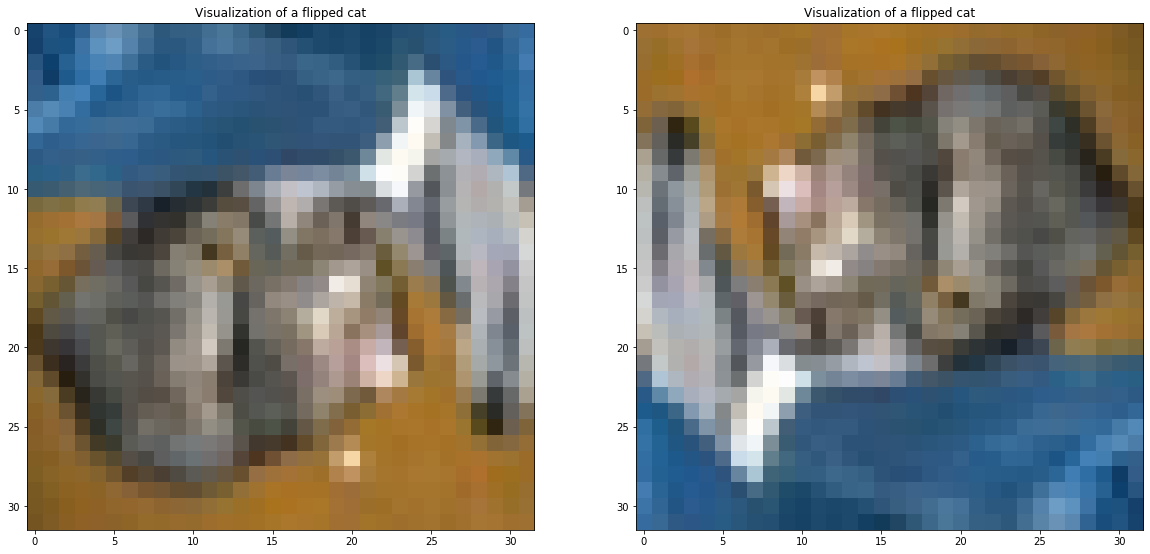

In [46]:
non_flipped_cat = X_te[Y_te == 3][0]
flipped_cat = X_te_flipped[Y_te == 3][0]
fig, axes = plt.subplots(1, 2, figsize = (20, 10))
axes[0].imshow(flipped_cat.permute((1, 2, 0)))
axes[0].set_title('Visualization of a flipped cat')
axes[1].imshow(non_flipped_cat.permute((1, 2, 0)))
axes[1].set_title('Visualization of a flipped cat')
plt.savefig('Flipped_unflipped_cat.png')
plt.show(fig)

##### Test performances

In [47]:
test_loss, test_acc = evaluate(model, flipped_test_dl)
print(test_loss)
print('The performances on the flipped test set are ', test_acc)

3.1374869140625
The performances on the flipped test set are  0.416


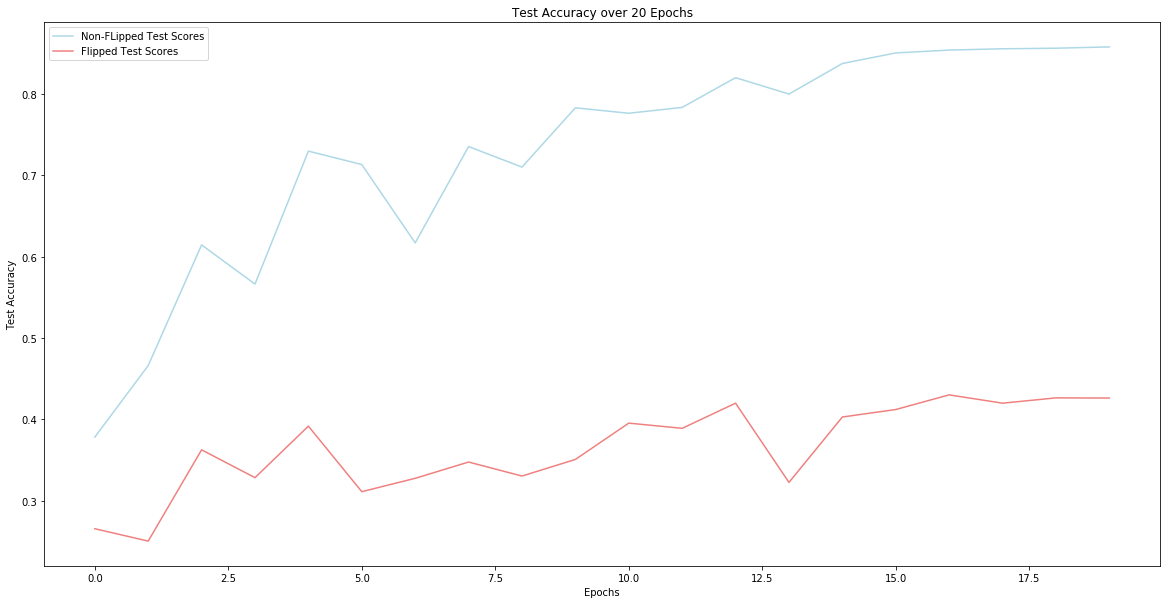

In [55]:
fig = plt.figure(figsize = (20, 10))
plt.plot(test_scores, color= 'lightblue', label='Non-FLipped Test Scores')
plt.plot(flipped_test_scores, color='lightcoral', label='Flipped Test Scores')
plt.title('Test Accuracy over 20 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.savefig('Performances_after_20_epochs.png')
plt.show(fig)

Let's see what happens when we train our model for several more epochs. What is good with the Cross Entropy training loss, it's that we can keep on trainijng even though our training accuracy is perfect (we deal with probabilities and not with labels).

In [ ]:
model = make_cnn()
opt = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 80
test_scores = []
flipped_test_scores = []
for i in range(epochs):
    print(f'Starting Epoch {i}')
    train_loss, train_acc = train_epoch(model, train_dl, opt)
    test_loss, test_acc = evaluate(model, test_dl)
    flipped_test_loss, flipped_test_acc = evaluate(model, flipped_test_dl)
    test_scores.append(test_acc)
    flipped_test_scores.append(flipped_test_acc)
    print(f'Epoch {i}:\t Train Loss: {train_loss:.3f} \t Train Acc: {train_acc:.3f}\t Test Acc: {test_acc:.3f}')
fig = plt.figure(figsize = (20, 10))
plt.plot(test_scores, color= 'lightblue', label='Non-FLipped Test Scores')
plt.plot(flipped_test_scores, color='lightcoral', label='Flipped Test Scores')
plt.title('Test Accuracy over 80 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.savefig('Performances_after_80_epochs.png')
plt.show(fig)

Starting Epoch 0


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 4.791 	 Train Acc: 0.163
	 [Batch 100 / 391] Train Loss: 3.453 	 Train Acc: 0.189
	 [Batch 150 / 391] Train Loss: 2.966 	 Train Acc: 0.215
	 [Batch 200 / 391] Train Loss: 2.696 	 Train Acc: 0.238
	 [Batch 250 / 391] Train Loss: 2.520 	 Train Acc: 0.257
	 [Batch 300 / 391] Train Loss: 2.389 	 Train Acc: 0.275
	 [Batch 350 / 391] Train Loss: 2.285 	 Train Acc: 0.292
Epoch 0:	 Train Loss: 2.213 	 Train Acc: 0.305	 Test Acc: 0.408
Starting Epoch 1


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.550 	 Train Acc: 0.431
	 [Batch 100 / 391] Train Loss: 1.516 	 Train Acc: 0.449
	 [Batch 150 / 391] Train Loss: 1.497 	 Train Acc: 0.456
	 [Batch 200 / 391] Train Loss: 1.475 	 Train Acc: 0.464
	 [Batch 250 / 391] Train Loss: 1.457 	 Train Acc: 0.471
	 [Batch 300 / 391] Train Loss: 1.428 	 Train Acc: 0.481
	 [Batch 350 / 391] Train Loss: 1.408 	 Train Acc: 0.489
Epoch 1:	 Train Loss: 1.391 	 Train Acc: 0.496	 Test Acc: 0.498
Starting Epoch 2


  0%|          | 0/391 [00:00<?, ?it/s]

	 [Batch 50 / 391] Train Loss: 1.227 	 Train Acc: 0.562


##### Test performances over classes, over epochs

In [ ]:
def evaluate_per_class(model, test_dl, loss_func=nn.CrossEntropyLoss().cuda()):
    ''' Returns loss, acc per class'''
    model.eval()
    model.cuda()
    nCorrect = 0.0
    nTotal = 0
    net_loss = 0.0
    with torch.no_grad():
        for (xb, yb) in test_dl:
            xb, yb = xb.cuda(), yb.cuda()
            outputs = model(xb)
            loss = len(xb) * loss_func(outputs, yb)
            _, preds = torch.max(outputs, dim=1)
            nCorrect += (preds == yb).float().sum()
            net_loss += loss
            nTotal += preds.size(0)

    acc = nCorrect.cpu().item() / float(nTotal)
    loss = net_loss.cpu().item() / float(nTotal)
    return loss, acc